## 필요 라이브러리 및 데이터셋 로드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import minmax_scale
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#merged csv 불러오기
path = "/content/drive/MyDrive/eda/merged.csv"
cols = ["가입자 일련번호", "성별코드", "연령대코드", "시도코드", "주상병코드", '요양일수', '입내원일수', '심결가산율', '심결요양급여비용총액', '심결본인부담금',
       '심결보험자부담금', '총처방일수']
df_raw = pd.read_csv(path, usecols = cols, encoding="utf-8")

#데이터프레임 복사
temp = df_raw.copy(deep = True)

#메모리 free
del df_raw
gc.collect()

#["주상병코드"] 데이터 대분류로 축소
temp["주상병코드"] = temp["주상병코드"].str.slice(0,1)

#시는 si, 도는 do로 변환
temp["시도코드"] = temp["시도코드"].replace(
    {11 : "si"
    ,26 : "si"
    ,27 : "si"
    ,28 : "si"
    ,29 : "si"
    ,30 : "si"
    ,31 : "si"
    ,36 : "si"
    ,41 : "do"
    ,42 : "do"
    ,43 : "do"
    ,44 : "do"
    ,45 : "do"
    ,46 : "do"
    ,47 : "do"
    ,48 : "do"
    ,49 : "do"})

#주상병코드, 시도코드 원핫인코딩
temp = pd.get_dummies(temp, columns=["주상병코드", "시도코드"])

#Normalization 해줘야하는 칼럼 리스트로 정리
norm_cols = ["성별코드", "연령대코드", "요양일수", "입내원일수", "심결가산율", "심결요양급여비용총액", "심결본인부담금", "심결보험자부담금", "총처방일수"]

#normalization 수행
for column in norm_cols:
  data = temp[column]
  temp[column] = minmax_scale(data)

#normalization 결과 확인
temp

,가입자 일련번호,성별코드,연령대코드,요양일수,입내원일수,심결가산율,심결요양급여비용총액,심결본인부담금,심결보험자부담금,총처방일수,...,주상병코드_O,주상병코드_P,주상병코드_Q,주상병코드_R,주상병코드_S,주상병코드_T,주상병코드_U,주상병코드_Z,시도코드_do,시도코드_si
0,334176,1.0,0.882353,0.004115,0.001190,0.500000,0.000055,0.000071,0.000050,0.033333,...,0,0,0,0,0,0,0,0,1,0
1,334176,1.0,0.882353,0.004115,0.001190,0.500000,0.000055,0.000071,0.000050,0.033333,...,0,0,0,0,0,0,0,0,1,0
2,334209,1.0,0.764706,0.004115,0.001190,0.500000,0.000055,0.000071,0.000050,0.066667,...,0,0,0,0,0,0,0,0,1,0
3,334265,1.0,0.823529,0.004115,0.001190,0.500000,0.000055,0.000071,0.000050,0.066667,...,0,0,0,0,0,0,0,0,1,0
4,335323,1.0,0.764706,0.004115,0.001190,0.500000,0.000055,0.000071,0.000050,0.033333,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11733708,995389,0.0,0.117647,0.008230,0.010714,1.000000,0.005665,0.001727,0.005785,0.000000,...,0,0,0,0,0,0,0,0,1,0
11733709,996077,1.0,0.117647,0.008230,0.003571,0.833333,0.003978,0.002101,0.003969,0.000000,...,0,0,0,0,1,0,0,0,1,0
11733710,997217,0.0,0.117647,0.004115,0.107143,1.000000,0.002877,0.002850,0.002729,0.000000,...,0,0,0,0,0,0,0,0,1,0
11733711,997217,0.0,0.117647,0.045267,0.120238,1.000000,0.023609,0.014582,0.023329,0.000000,...,0,0,0,0,0,0,0,0,1,0


## 메모리 초과 방지를 위해 샘플추출

In [ ]:
#재현을 위한 random_state 지정 및 샘플 1,000,000개 추출
sample = temp.sample(n=1000000, random_state=777)

In [ ]:
# 메모리 free
del temp
gc.collect

<function gc.collect(generation=2)>

In [ ]:
#가입자 일련번호 분리
patient_id = sample["가입자 일련번호"]

#가입자 번호 drop
sample.drop(columns=["가입자 일련번호"], inplace = True)

In [ ]:
#sample 확인
sample

,성별코드,연령대코드,요양일수,입내원일수,심결가산율,심결요양급여비용총액,심결본인부담금,심결보험자부담금,총처방일수,주상병코드_A,...,주상병코드_O,주상병코드_P,주상병코드_Q,주상병코드_R,주상병코드_S,주상병코드_T,주상병코드_U,주상병코드_Z,시도코드_do,시도코드_si
9264829,1.0,0.882353,0.004115,0.00119,0.5,0.000082,0.000080,0.000078,0.066667,0,...,0,0,0,0,0,0,0,0,0,1
4183884,0.0,0.823529,0.004115,0.00119,0.5,0.000059,0.000071,0.000054,0.001111,0,...,0,0,0,0,0,0,0,0,0,1
8966295,1.0,0.882353,0.004115,0.00119,0.5,0.000082,0.000080,0.000078,0.033333,0,...,0,0,0,0,0,0,0,0,1,0
5838057,0.0,0.764706,0.004115,0.00119,0.5,0.000076,0.000076,0.000072,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
2452469,0.0,0.647059,0.004115,0.00119,0.5,0.000307,0.000912,0.000227,0.007778,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5726105,1.0,0.705882,0.004115,0.00119,0.5,0.000148,0.000440,0.000110,0.001111,0,...,0,0,0,0,0,0,0,0,0,1
5637088,0.0,0.058824,0.004115,0.00119,0.5,0.000179,0.000529,0.000132,0.001111,0,...,0,0,0,0,0,0,0,0,0,1
5140939,0.0,0.705882,0.004115,0.00119,0.5,0.000070,0.000208,0.000052,0.033333,0,...,0,0,0,0,0,0,0,0,0,1
8954746,0.0,0.764706,0.004115,0.00119,0.5,0.000082,0.000080,0.000078,0.000000,0,...,0,0,0,0,0,0,0,0,1,0


## Scree plot 작도

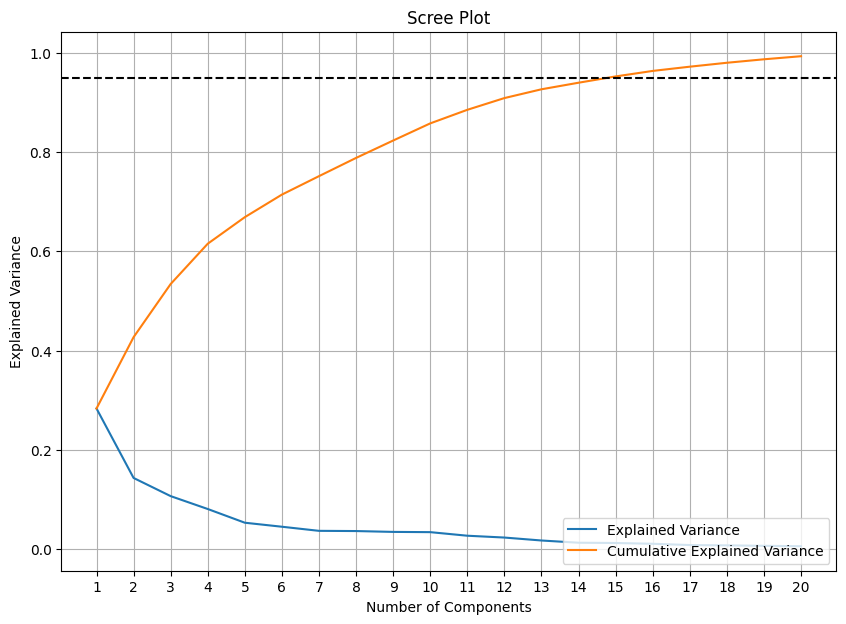

In [ ]:
# PCA 수행하여 각 Principal component 별 explained variance 획득
pca = PCA(n_components=20).fit(sample)

# Scree plot 작도 + cumulative explained variance ratio 작도
plt.figure(figsize = (10,7))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, label='Explained Variance')
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), label='Cumulative Explained Variance')
plt.axhline(y=0.95, color = "black", linestyle = "--")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.grid(visible = True)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.legend(loc = "lower right")
plt.show()
